<a href="https://colab.research.google.com/github/MahlaMirali/Genomics_MachineLearning/blob/master/Genomics_ML_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import libraries/ file

In [ ]:
!pip install -U git+http://github.com/scikit-learn-contrib/imbalanced-learn.git
# !pip install -U imbalanced-learn
%matplotlib inline
import matplotlib.pyplot as plt
from google.colab import drive
import pandas as pd
import numpy as np
from pprint import pprint

# dealing with imbalanced data
from imblearn.over_sampling import SMOTE 
from imblearn.over_sampling import RandomOverSampler 
from imblearn.datasets import make_imbalance
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [ ]:
# Read data from goolge colab
drive.mount('/content/drive')
!cp '/content/drive/My Drive/clauw.2016/DNA.csv' 'DNA.csv'
!ls

# EDA

In [4]:
# reading the DNA file
DNA = pd.read_csv('DNA.csv')
print(len(DNA))
# removing the unnmaed column
DNA.rename({"Unnamed: 0":"a"}, axis="columns", inplace=True)
DNA.drop(["a"], axis=1, inplace=True)
DNA.head(5)

925


,Sequence,Stress
0,ATGGGAAATAGCAGCGAGGAACCAAAGCCTCCTACCAAATCAGATA...,0
1,ATGGGAAATAGCAGCGAGGAACCAAAGCCTCCTACCAAATCAGATA...,0
2,ATGGGAAATAGCAGCGAGGAACCAAAGCCTCCTACCAAATCAGATA...,0
3,ATGACAGAAGGTGGAGAATATTCTCCGGCGATGATGTCAGCAGAGC...,0
4,ATGACAGAAGGTGGAGAATATTCTCCGGCGATGATGTCAGCAGAGC...,0


In [44]:
print(DNA['Sequence'][0])
print(len(DNA['Sequence'][0]))

ATGGGAAATAGCAGCGAGGAACCAAAGCCTCCTACCAAATCAGATAAACCATCTTCACCCCCGGTGGATCAAACAAATGTTCATGTCTACCCTGATTGGGCAGCTATGCAGGCATATTATGGTCCAAGAGTAGCAATGCCTCCTTATTACAATTCAGCTATGGCTGCATCTGGTCATCCTCCTCCTCCTTACATGTGGAATCCTCAGCATATGATGTCACCATATGGAGCACCCTATGCTGCTGTTTATCCTCATGGAGGAGGAGTTTACGCTCATCCCGGTATTCCCATGGGATCACTGCCTCAAGGTCAAAAGGATCCACCTTTAACAACTCCGGGGACGCTTTTGAGCATCGACACTCCTACTAAATCTACAGGGAACACAGACAATGGATTGATGAAGAAGCTGAAAGAGTTTGATGGGCTTGCTATGTCTCTAGGAAATGGGAATCCTGAAAATGGTGCAGATGAACATAAACGATCACGGAACAGCTCAGAAACTGATGGTTCTACTGATGGAAGTGATGGGAATACAACTGGGGCAGATGAACCGAAACTTAAAAGAAGTCGAGAGGGAACTCCAACAAAAGATGGGAAACAATTGGTTCAAGCTAGCTCATTTCATTCTGTTTCTCCGTCAAGTGGTGATACCGGCGTAAAACTCATTCAAGGATCTGGAGCTATACTCTCTCCTGGTAACGAGAGAGAACTGAAACGGGAGCGAAGGAAACAGTCTAATAGAGAATCTGCTAGAAGGTCAAGATTAAGGAAACAGGCCGAGACAGAAGAACTTGCTAGGAAAGTGGAAGCCTTGACAGCCGAAAACATGGCATTAAGATCTGAACTAAACCAACTTAATGAGAAATCTGATAAACTAAGAGGAGCAAATGCAACCTTGTTGGACAAACTGAAATGCTCGGAACCCGAAAAGAGAGTCCCCGCAAATATGTTGTCTAGAGTTAAGAACTCAGGAGCTGGAGATAAGAACAAGAACCAAGGAG

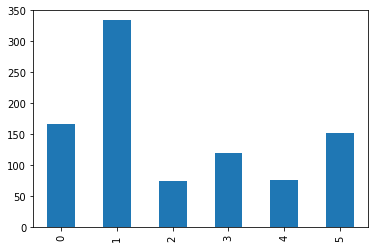

In [ ]:
# check the balance of the dataset
DNA['Stress'].value_counts().sort_index().plot.bar()
# 0:'ABA', 1:'Overdrou', 2:'OSM', 3:'JA', 4:'ET', 5:'WaterDepr'

# Data Preprocessing

In [5]:
# changing the sequences into words
def getKmers(sequence, size=6):
  return[sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

DNA['words'] = DNA.apply(lambda x:getKmers(x['Sequence']), axis=1)
DNA = DNA.drop(['Sequence'], axis=1)
DNA_texts =  list(DNA['words'])

for item in range(len(DNA_texts)):
  # if len(DNA['words']) == 6:
    DNA_texts[item] = ' '.join(DNA_texts[item])

# creating the bag of words
cv = CountVectorizer(ngram_range=(4,4))
x = cv.fit_transform(DNA_texts)
# print(cv.get_feature_names())    

# Functions

In [8]:
def model_fit(model, DNA):
    y = DNA.iloc[:,0].values
    x = cv.fit_transform(DNA_texts)
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
    # undersampling since the dataset is imbalanced
    pipeline = make_pipeline(NearMiss(version=2), model)
    pipeline.fit(x_train, y_train)
    print(classification_report_imbalanced(y_test, pipeline.predict(x_test))) # precision/recall/specificity, geometric mean, and index balanced accuracy of the geometric mean
    return x_train, x_test, y_train, y_test

def BestParams(model, param_grid):
    # Create a based model
    grid_search = GridSearchCV(model, param_grid = param_grid) #, cv = 5, n_jobs = -1, verbose = 2)
    # Fit the grid search to the data
    grid_search.fit(x_train, y_train)
    print(grid_search.best_params_) 

# Model #1: Random Forest

Original Model

In [9]:
x_train, x_test, y_train, y_test = model_fit(RandomForestClassifier(), DNA) 

                   pre       rec       spe        f1       geo       iba       sup

          0       0.10      0.07      0.86      0.09      0.25      0.06        41
          1       0.73      0.32      0.92      0.45      0.55      0.28        93
          2       0.27      0.53      0.90      0.36      0.69      0.46        15
          3       0.18      0.47      0.66      0.26      0.55      0.30        32
          4       0.06      0.13      0.87      0.09      0.34      0.11        15
          5       0.24      0.11      0.93      0.15      0.32      0.10        36

avg / total       0.39      0.27      0.87      0.28      0.46      0.22       232



Hyperparameters tuning

In [11]:
model = RandomForestClassifier()
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 40],
    # 'max_features': [30, 70],
    'min_samples_leaf': [4,8],
    'min_samples_split': [8,  12],
    'n_estimators': [50, 200, 600]
}

BestParams(model, param_grid)

{'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 12, 'n_estimators': 600}


Tuned Model

In [12]:
x_train, x_test, y_train, y_test = model_fit(RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_leaf=4,
                                 min_samples_split=12, n_estimators=600), DNA)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.13      0.17      0.75      0.15      0.36      0.12        41
          1       0.87      0.22      0.98      0.34      0.46      0.19        93
          2       0.18      0.53      0.83      0.27      0.67      0.43        15
          3       0.42      0.16      0.96      0.23      0.39      0.14        32
          4       0.04      0.13      0.76      0.06      0.32      0.10        15
          5       0.13      0.17      0.80      0.15      0.37      0.13        36

avg / total       0.46      0.21      0.89      0.24      0.42      0.17       232



# Model #2: Naive Bayes

Original Model

In [13]:
x_train, x_test, y_train, y_test = model_fit(MultinomialNB(), DNA)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.10      0.15      0.73      0.12      0.33      0.10        41
          1       0.76      0.41      0.91      0.53      0.61      0.35        93
          2       0.27      0.53      0.90      0.36      0.69      0.46        15
          3       0.30      0.31      0.89      0.31      0.53      0.26        32
          4       0.08      0.13      0.89      0.10      0.34      0.11        15
          5       0.14      0.14      0.85      0.14      0.34      0.11        36

avg / total       0.41      0.30      0.86      0.33      0.50      0.25       232



Hyperparameters Tuning

In [14]:
model = MultinomialNB()
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 1, 10], # smoothing parameter
    'fit_prior': [ True, False]}
BestParams(model, param_grid)

{'alpha': 0.01, 'fit_prior': True}


Tuned Model

In [15]:
x_train, x_test, y_train, y_test = model_fit(MultinomialNB(alpha=0.01, fit_prior=True), DNA)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.12      0.12      0.81      0.12      0.31      0.09        41
          1       0.70      0.42      0.88      0.52      0.61      0.35        93
          2       0.22      0.53      0.87      0.31      0.68      0.45        15
          3       0.33      0.31      0.90      0.32      0.53      0.26        32
          4       0.06      0.13      0.84      0.08      0.34      0.10        15
          5       0.15      0.14      0.86      0.14      0.35      0.11        36

avg / total       0.39      0.30      0.86      0.32      0.49      0.25       232



# Model #3: KNN

Original Model

In [16]:
x_train, x_test, y_train, y_test = model_fit(KNeighborsClassifier(), DNA)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.22      0.20      0.85      0.21      0.41      0.16        41
          1       0.94      0.16      0.99      0.28      0.40      0.15        93
          2       0.24      0.27      0.94      0.25      0.50      0.23        15
          3       0.16      0.59      0.49      0.25      0.54      0.29        32
          4       0.06      0.13      0.87      0.09      0.34      0.11        15
          5       0.18      0.06      0.95      0.09      0.23      0.05        36

avg / total       0.48      0.22      0.88      0.22      0.40      0.16       232



Hyperparameters tuning

In [17]:
model = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5,10,20, 50], 
    'weights': [ 'uniform', 'distance'], 
    'metric': ['euclidean', 'manhattan','minkowski']}

BestParams(model, param_grid)

{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}


Tuned Model

In [18]:
x_train, x_test, y_train, y_test = model_fit(KNeighborsClassifier(metric='euclidean', n_neighbors=3, weights= 'uniform'), DNA)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.17      0.17      0.83      0.17      0.38      0.13        41
          1       0.58      0.86      0.58      0.69      0.71      0.52        93
          2       0.24      0.27      0.94      0.25      0.50      0.23        15
          3       0.31      0.12      0.95      0.18      0.35      0.11        32
          4       0.10      0.13      0.91      0.11      0.35      0.11        15
          5       0.67      0.06      0.99      0.10      0.24      0.05        36

avg / total       0.43      0.43      0.79      0.37      0.49      0.28       232



# Model #4: SVM

Original Model

In [19]:
x_train, x_test, y_train, y_test = model_fit(SVC(), DNA)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.07      0.02      0.93      0.04      0.15      0.02        41
          1       0.66      0.20      0.93      0.31      0.44      0.18        93
          2       0.08      0.60      0.52      0.14      0.56      0.31        15
          3       0.33      0.25      0.92      0.29      0.48      0.21        32
          4       0.07      0.13      0.88      0.09      0.34      0.11        15
          5       0.22      0.14      0.91      0.17      0.36      0.12        36

avg / total       0.36      0.19      0.89      0.21      0.38      0.15       232



Hyperparameters Tuning

In [20]:
model = SVC()
param_grid = {
    'C': [ 0.1, 1, 10], 
    'gamma': [0.1,0.01,0.001], # for rbf
    'kernel': ['rbf', 'poly'],
    'degree': [1,2,3]
}
BestParams(model, param_grid)

{'C': 0.1, 'degree': 1, 'gamma': 0.01, 'kernel': 'poly'}


Tuned Model

In [21]:
x_train, x_test, y_train, y_test =  model_fit(SVC(C=0.1, kernel= 'poly', degree=1), DNA)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.13      0.37      0.47      0.19      0.41      0.17        41
          1       0.78      0.30      0.94      0.43      0.53      0.27        93
          2       0.23      0.33      0.92      0.27      0.55      0.29        15
          3       0.35      0.19      0.94      0.24      0.42      0.16        32
          4       0.22      0.13      0.97      0.17      0.36      0.12        15
          5       0.19      0.17      0.87      0.18      0.38      0.14        36

avg / total       0.44      0.27      0.85      0.30      0.46      0.21       232

